In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math
from datetime import datetime, time

from sklearn.impute import KNNImputer

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#change display options
pd.set_option("display.max_rows", 160)
pd.set_option("display.max_columns", 80)

In [2]:
# import datasets
df_train = pd.read_csv('../assets/train.csv')
df_spray = pd.read_csv('../assets/spray.csv')
df_weather = pd.read_csv('../assets/weather.csv')
map_data = np.loadtxt('../assets/mapdata_copyright_openstreetmap_contributors.txt')
df_test = pd.read_csv('../assets/test.csv')

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

- Id: the id of the record
- Date: date that the WNV test is performed
- Address: approximate address of the location of trap. This is used to send to the GeoCoder. 
- Species: the species of mosquitos
- Block: block number of address
- Street: street name
- Trap: Id of the trap
- AddressNumberAndStreet: approximate address returned from GeoCoder
- Latitude, Longitude: Latitude and Longitude returned from GeoCoder
- AddressAccuracy: accuracy returned from GeoCoder
- NumMosquitos: number of mosquitoes caught in this trap
- WnvPresent: whether West Nile Virus was present in these mosquitos. 1 means WNV is present, and 0 means not present. 

## Cleaning Datasets

### Train Dataset

In [3]:
df_train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


In [5]:
df_train.isnull().sum()

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [6]:
# converting Date in train dataset to python readable date-time format
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [7]:
# Date range:
print(f'From:{df_train["Date"].min()}')
print(f"To:{df_train['Date'].max()}")

From:2007-05-29 00:00:00
To:2013-09-26 00:00:00


### Spray Dataset

The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

In [8]:
df_spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [9]:
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [10]:
df_spray.isnull().sum()

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

In [11]:
df_spray.head(10)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858
5,2011-08-29,6:57:48 PM,42.390395,-88.088315
6,2011-08-29,6:57:58 PM,42.390673,-88.088002
7,2011-08-29,6:58:08 PM,42.391027,-88.088002
8,2011-08-29,6:58:18 PM,42.391403,-88.088003
9,2011-08-29,6:58:28 PM,42.391718,-88.087995


In [12]:
# Check that null values from Time column only occurs for 2011-09-07
df_spray[df_spray["Time"].isnull()].groupby("Date").Latitude.count()

Date
2011-09-07    584
Name: Latitude, dtype: int64

In [13]:
# Mode/Median for spray timing on 2011-09-07
print(f'Mode: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).mode()}')
print(f'Median: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).median()}')
print(f'Min: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).min()}')
print(f'Max: {pd.to_datetime(df_spray[df_spray["Date"]=="2011-09-07"]["Time"]).max()}')

Mode: 0   2022-12-09 19:44:32
Name: Time, dtype: datetime64[ns]
Median: 2022-12-09 20:11:06
Min: 2022-12-09 19:42:12
Max: 2022-12-09 21:41:10


Text(0.5, 0, 'Time')

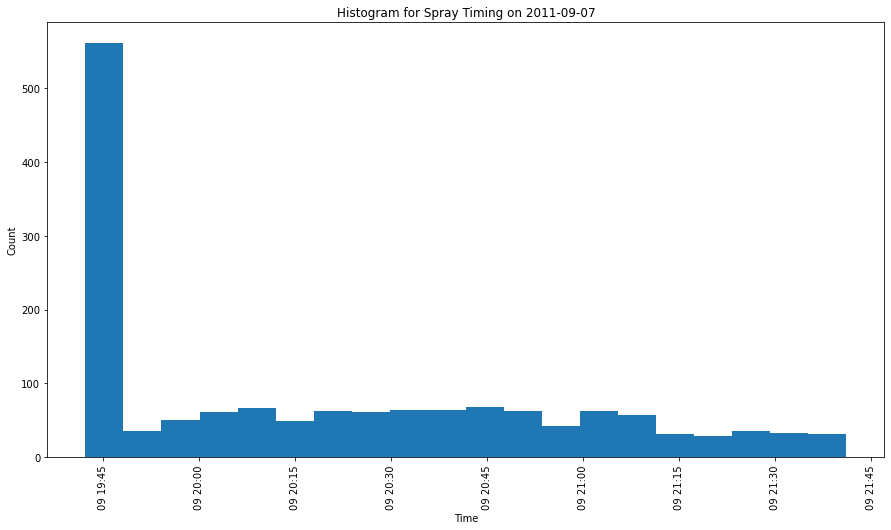

In [14]:
# Plotting histogram of spray timing
df_spray_0907 = df_spray[df_spray["Date"]=='2011-09-07']
plt.figure(figsize =(15,8))
plt.xticks(rotation=90)
df_spray_1 = df_spray_0907[df_spray_0907["Time"].notnull()]
plt.hist(pd.to_datetime(df_spray_1['Time']),bins = 20)
plt.title("Histogram for Spray Timing on 2011-09-07")
plt.ylabel("Count")
plt.xlabel("Time")

In [15]:
# replacing null values in df_spray "Time" column with mode timing
df_spray["Time"].fillna("7:44:32 PM", inplace = True)
df_spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14835 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [16]:
#create datetime column:
df_spray["datetime"] = df_spray["Date"] + " " + df_spray["Time"]
df_spray.head()

,Date,Time,Latitude,Longitude,datetime
0,2011-08-29,6:56:58 PM,42.391623,-88.089163,2011-08-29 6:56:58 PM
1,2011-08-29,6:57:08 PM,42.391348,-88.089163,2011-08-29 6:57:08 PM
2,2011-08-29,6:57:18 PM,42.391022,-88.089157,2011-08-29 6:57:18 PM
3,2011-08-29,6:57:28 PM,42.390637,-88.089158,2011-08-29 6:57:28 PM
4,2011-08-29,6:57:38 PM,42.390410,-88.088858,2011-08-29 6:57:38 PM


In [17]:
# converting to python readable date-time format
df_spray['datetime'] = pd.to_datetime(df_spray['datetime'])

In [18]:
# set datetime column to be the index
df_spray.set_index('datetime', inplace=True)

In [19]:
df_spray.head()

,Date,Time,Latitude,Longitude
datetime,,,,
2011-08-29 18:56:58,2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29 18:57:08,2011-08-29,6:57:08 PM,42.391348,-88.089163
2011-08-29 18:57:18,2011-08-29,6:57:18 PM,42.391022,-88.089157
2011-08-29 18:57:28,2011-08-29,6:57:28 PM,42.390637,-88.089158
2011-08-29 18:57:38,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [20]:
# Date range:
print(f'From:{df_spray["Date"].min()}')
print(f"To:{df_spray['Date'].max()}")

From:2011-08-29
To:2013-09-05


### Weather

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [21]:
df_weather.head(50)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [22]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

In [23]:
# converting Date in train dataset to python readable date-time format
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

In [24]:
df_weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [25]:
# replace M with NaN
df_weather.replace(to_replace= "M", value=np.NaN, inplace = True)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   object        
 5   Depart       1472 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   object        
 8   Heat         2933 non-null   object        
 9   Cool         2933 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        1472 non-null   object        
 14  Water1       0 non-null      float64       
 15  SnowFall     1472 non-null   object        
 16  Precip

##### Tavg

In [26]:
# replacing missing values in Tavg with cal avg of Tmax and Tmin 
df_weather["Tavg"] = df_weather.loc[:,["Tmax","Tmin"]].mean(axis = 1).apply(np.ceil)
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   Depart       1472 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2940 non-null   object        
 8   Heat         2933 non-null   object        
 9   Cool         2933 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        1472 non-null   object        
 14  Water1       0 non-null      float64       
 15  SnowFall     1472 non-null   object        
 16  Precip

##### Depart

In [27]:
# breaking down dataset into respective stations
df_weather_1 = df_weather[df_weather["Station"]==1]
df_weather_2 = df_weather[df_weather["Station"]==2]
df_weather_1 = df_weather_1.reset_index()
df_weather_2 = df_weather_2.reset_index()

In [28]:
# checking missing values in Depart column
display(df_weather_1.head())
display(df_weather_2.head())

,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,0,1,2007-05-01,83,50,67.0,14,51,56,0,2,0448,1849,,0,NaN,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,1,2007-05-02,59,42,51.0,-3,42,47,14,0,0447,1850,BR,0,NaN,0.0,0.00,29.38,30.09,13.0,4,13.4
2,4,1,2007-05-03,66,46,56.0,2,40,48,9,0,0446,1851,,0,NaN,0.0,0.00,29.39,30.12,11.7,7,11.9
3,6,1,2007-05-04,66,49,58.0,4,41,50,7,0,0444,1852,RA,0,NaN,0.0,T,29.31,30.05,10.4,8,10.8
4,8,1,2007-05-05,66,53,60.0,5,38,49,5,0,0443,1853,,0,NaN,0.0,T,29.40,30.10,11.7,7,12.0


,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2,2007-05-01,84,52,68.0,NaN,51,57,0,3,-,-,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6
1,3,2,2007-05-02,60,43,52.0,NaN,42,47,13,0,-,-,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4
2,5,2,2007-05-03,67,48,58.0,NaN,40,50,7,0,-,-,HZ,NaN,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2
3,7,2,2007-05-04,78,51,65.0,NaN,42,50,NaN,NaN,-,-,,NaN,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4
4,9,2,2007-05-05,66,54,60.0,NaN,39,50,5,0,-,-,,NaN,NaN,NaN,T,29.46,30.09,11.2,7,11.5


In [29]:
# calculate 30 year normal temperature from station 1 and merge to station 2 dataset
df_weather_1["Depart"] = df_weather_1["Depart"].astype(float)
df_weather_2["30_yr_temp"]= df_weather_1["Tavg"] - df_weather_1["Depart"].astype(float)

In [30]:
# Calculate Depart value for station 2
df_weather_2["Depart"] = df_weather_2["Tavg"] - df_weather_2["30_yr_temp"]
df_weather_2.head()

,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,30_yr_temp
0,1,2,2007-05-01,84,52,68.0,15.0,51,57,0,3,-,-,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,53.0
1,3,2,2007-05-02,60,43,52.0,-2.0,42,47,13,0,-,-,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,54.0
2,5,2,2007-05-03,67,48,58.0,4.0,40,50,7,0,-,-,HZ,NaN,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2,54.0
3,7,2,2007-05-04,78,51,65.0,11.0,42,50,NaN,NaN,-,-,,NaN,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4,54.0
4,9,2,2007-05-05,66,54,60.0,5.0,39,50,5,0,-,-,,NaN,NaN,NaN,T,29.46,30.09,11.2,7,11.5,55.0


##### Wet Bulb

In [31]:
# checking for null values
display(df_weather_1[df_weather_1["WetBulb"].isnull()])
display(df_weather_2[df_weather_2["WetBulb"].isnull()])

,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
424,848,1,2009-06-26,86,69,78.0,7.0,60,NaN,0,13,0418,1931,,0,NaN,0.0,0.00,NaN,29.85,6.4,4,8.2
1205,2410,1,2013-08-10,81,64,73.0,0.0,57,NaN,0,8,0454,1900,,0,NaN,0.0,0.00,NaN,30.08,5.3,5,6.5
1206,2412,1,2013-08-11,81,60,71.0,-2.0,61,NaN,0,6,0455,1859,RA,0,NaN,0.0,0.01,29.35,30.07,2.0,27,3.0


,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,30_yr_temp
1207,2415,2,2013-08-12,85,69,77.0,4.0,63,NaN,0,12,-,-,RA,NaN,NaN,NaN,0.66,29.27,29.92,4.5,26,7.7,73.0


In [32]:
# replace null values
df_weather_1["WetBulb"]=df_weather_1["WetBulb"].fillna(method="ffill").astype(float)
df_weather_2["WetBulb"]=df_weather_2["WetBulb"].fillna(method="ffill").astype(float)

##### Heat/Cool

In [33]:
# Port over Heat values from station 1 to replace null values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"Heat"] is np.NaN:
        df_weather_2.loc[i,"Heat"] = df_weather_1.loc[i,"Heat"]
        
# Port over Cool values from station 1 to replace null values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"Cool"] is np.NaN:
        df_weather_2.loc[i,"Cool"] = df_weather_1.loc[i,"Cool"]

In [34]:
# change to float
df_weather_1["Heat"] = df_weather_1["Heat"].astype(float) 
df_weather_2["Heat"] = df_weather_2["Heat"].astype(float)

In [35]:
# change to float
df_weather_1["Cool"] = df_weather_1["Cool"].astype(float) 
df_weather_2["Cool"] = df_weather_2["Cool"].astype(float) 

#### Sunrise/Sunset

In [36]:
# Check on unique values for sunrise in station 2
df_weather_2["Sunrise"].unique()

array(['-'], dtype=object)

In [37]:
# Check on unique values for sunset in station 2
df_weather_2["Sunset"].unique()

array(['-'], dtype=object)

In [38]:
# Port over Sunrise values from station 1 to replace "-" values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"Sunrise"] is "-":
        df_weather_2.loc[i,"Sunrise"] = df_weather_1.loc[i,"Sunrise"]

# Port over Sunset values from station 1 to replace "-" values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"Sunset"] is "-":
        df_weather_2.loc[i,"Sunset"] = df_weather_1.loc[i,"Sunset"]

In [39]:
df_weather_2.head()

,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,30_yr_temp
0,1,2,2007-05-01,84,52,68.0,15.0,51,57.0,0.0,3.0,0448,1849,,NaN,NaN,NaN,0.00,29.18,29.82,2.7,25,9.6,53.0
1,3,2,2007-05-02,60,43,52.0,-2.0,42,47.0,13.0,0.0,0447,1850,BR HZ,NaN,NaN,NaN,0.00,29.44,30.08,13.3,2,13.4,54.0
2,5,2,2007-05-03,67,48,58.0,4.0,40,50.0,7.0,0.0,0446,1851,HZ,NaN,NaN,NaN,0.00,29.46,30.12,12.9,6,13.2,54.0
3,7,2,2007-05-04,78,51,65.0,11.0,42,50.0,7.0,0.0,0444,1852,,NaN,NaN,NaN,0.00,29.36,30.04,10.1,7,10.4,54.0
4,9,2,2007-05-05,66,54,60.0,5.0,39,50.0,5.0,0.0,0443,1853,,NaN,NaN,NaN,T,29.46,30.09,11.2,7,11.5,55.0


In [40]:
# convert sunrise to python readable time format
df_weather_1["Sunrise_1"] = pd.to_datetime(df_weather_1['Sunrise'], format='%H%M')
df_weather_2["Sunrise_1"] = pd.to_datetime(df_weather_2['Sunrise'], format='%H%M')

In [41]:
# changing sunset values with e.g. 1860 to 1900, so that datatime method can convert values. 
# weather_1
for i in range(len(df_weather_1)):
    a = list((df_weather_1.loc[i,"Sunset"]))
    if a[2] == '6':
        a[2] = '0'
        a[1] = str(int(a[1]) + 1)
        df_weather_1.loc[i,"Sunset"] = ''.join(a)

#weather_2
for i in range(len(df_weather_2)):
    a = list((df_weather_2.loc[i,"Sunset"]))
    if a[2] == '6':
        a[2] = '0'
        a[1] = str(int(a[1]) + 1)
        df_weather_2.loc[i,"Sunset"] = ''.join(a)

In [42]:
# convert sunrise to python readable time format
df_weather_1["Sunset_1"] = pd.to_datetime(df_weather_1['Sunset'], format='%H%M')
df_weather_2["Sunset_1"] = pd.to_datetime(df_weather_2['Sunset'], format='%H%M')

In [43]:
# find delta duration between sunrise and sunset
df_weather_1["daylight_duration"] = df_weather_1["Sunset_1"] - df_weather_1["Sunrise_1"]
df_weather_2["daylight_duration"] = df_weather_2["Sunset_1"] - df_weather_2["Sunrise_1"]

In [131]:
df_weather_2["daylight_duration"].unique()

array([50460000000000, 50580000000000, 50700000000000, 50880000000000,
       51000000000000, 51180000000000, 51300000000000, 51480000000000,
       51600000000000, 51720000000000, 51840000000000, 51960000000000,
       52080000000000, 52200000000000, 52320000000000, 52440000000000,
       52560000000000, 52680000000000, 52800000000000, 52920000000000,
       53040000000000, 53160000000000, 53220000000000, 53340000000000,
       53460000000000, 53580000000000, 53640000000000, 53700000000000,
       53760000000000, 53880000000000, 53940000000000, 54060000000000,
       54180000000000, 54240000000000, 54360000000000, 54420000000000,
       54480000000000, 54540000000000, 54600000000000, 54660000000000,
       54720000000000, 54780000000000, 54840000000000, 54300000000000,
       54120000000000, 53820000000000, 53520000000000, 53400000000000,
       53280000000000, 52740000000000, 52620000000000, 52500000000000,
       52380000000000, 52260000000000, 52140000000000, 51360000000000,
      

##### Codesum

In [44]:
# replace blank values with Clear
df_weather_1["CodeSum"].replace(to_replace=' ',value="Clear", inplace = True)
df_weather_2["CodeSum"].replace(to_replace=' ',value="Clear", inplace = True)

In [45]:
display(df_weather_1["CodeSum"].unique())
display(df_weather_2["CodeSum"].unique())

array(['Clear', 'BR', 'RA', 'BR HZ', 'RA BR', 'RA VCTS', 'RA HZ',
       'TSRA RA BR HZ', 'HZ', 'TSRA BR HZ', 'TSRA RA BR', 'TSRA RA HZ',
       'TSRA BR HZ VCTS', 'TSRA', 'TSRA BR HZ FU', 'BR HZ FU',
       'TSRA RA VCTS', 'HZ VCTS', 'RA BR VCTS', 'TSRA RA BR VCTS',
       'DZ BR', 'TS TSRA RA BR HZ', 'RA BR HZ', 'TSRA RA',
       'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA', 'TS TSRA RA BR VCTS',
       'TS RA', 'TSRA BR', 'RA DZ FG+ BCFG BR', 'RA FG+ MIFG BR', 'RA DZ',
       'RA DZ BR', 'TSRA RA FG+ FG BR', 'TSRA DZ FG+ FG BR HZ', 'TS TSRA',
       'TSRA HZ', 'TS', 'FG+ BR HZ', 'TS TSRA BR HZ', 'DZ BR HZ',
       'TS TSRA BR', 'RA BR FU', 'TS BR HZ', 'FG+ BR', 'FG+ MIFG BR',
       'TSRA RA FG BR', 'DZ', 'RA DZ BR HZ', 'TS BR', 'TS RA FG+ FG BR',
       'RA DZ FG+ FG BR', 'RA BR SQ', 'RA FG BR', 'RA BR HZ FU',
       'MIFG BCFG BR', 'TSRA RA FG+ FG BR HZ', 'TSRA DZ BR HZ',
       'TS TSRA RA FG BR HZ', 'RA DZ FG+ BR', 'TSRA FG+ BR HZ',
       'FG+ FG BR HZ', 'FG BR HZ', 'TS RA BR HZ',

array(['Clear', 'BR HZ', 'HZ', 'TSRA RA BR', 'RA BR', 'TSRA RA', 'RA HZ',
       'TSRA BR HZ', 'RA BR HZ VCTS', 'RA', 'TSRA RA HZ', 'TSRA RA HZ FU',
       'BR', 'TSRA HZ', 'VCTS', 'TS TSRA RA BR HZ VCTS', 'TS TSRA BR HZ',
       'RA BR HZ', 'TSRA RA BR VCTS', 'TSRA RA DZ BR HZ', 'TSRA',
       'TS TSRA RA BR', 'TS RA BR', 'TS TSRA RA BR HZ', 'TS TSRA BR',
       'TSRA RA BR HZ', 'RA BCFG BR', 'TSRA BR', 'RA DZ', 'RA DZ BR',
       'TS TSRA RA HZ', 'TS BR', 'RA BR SQ', 'TS TSRA RA', 'TS RA',
       'TSRA RA VCTS', 'TSRA RA BR HZ VCTS', 'BR VCTS', 'RA SN',
       'TSRA RA DZ BR', 'DZ BR', 'DZ BR HZ', 'DZ', 'FG+ FG BR', 'FG+ BR',
       'TSRA FG+ BR', 'RA DZ BR HZ', 'RA DZ SN', 'FG+ FG BR HZ',
       'TS TSRA RA FG BR', 'TS BR HZ', 'BR HZ VCFG', 'TSRA RA FG+ BR',
       'TS TSRA RA VCTS', 'FU', 'TS', 'TS TSRA VCFG', 'TS TSRA HZ',
       'TS TSRA GR RA BR', 'HZ FU', 'RA BR HZ FU', 'FG+ BCFG BR',
       'TSRA RA FG+ FG BR', 'FG+', 'TSRA BR SQ', 'RA BR HZ VCFG',
       'RA FG+ BR', 'FG BR H

##### Depth

In [46]:
# check on Depth unique values
display(df_weather_1["Depth"].unique())
display(df_weather_2["Depth"].unique())

array(['0'], dtype=object)

array([nan], dtype=object)

In [47]:
# drop Depth since all 0 values
df_weather_1.drop("Depth", axis = 1, inplace = True)

# drop Depth since all nan values
df_weather_2.drop("Depth", axis = 1, inplace = True)

##### Water1

In [48]:
# drop Water1, since all null values
df_weather_1.drop("Water1", axis = 1, inplace = True)
df_weather_2.drop("Water1", axis = 1, inplace = True)

##### SnowFall

In [49]:
# check on SnowFall unique values
display(df_weather_1["SnowFall"].unique())
display(df_weather_2["SnowFall"].unique())

array(['0.0', '  T', '0.1'], dtype=object)

array([nan], dtype=object)

In [50]:
# replace Trace values with 0 - since a trace is anything less than can be measured
df_weather_1["SnowFall"].replace(to_replace= '  T', value="0.0", inplace = True)

In [51]:
# Port over SnowFall values from station 1 to replace "nan" values
for i in df_weather_2.index:
    if df_weather_2.loc[i,"SnowFall"] is np.NaN:
        df_weather_2.loc[i,"SnowFall"] = df_weather_1.loc[i,"SnowFall"]

In [52]:
# change to float datatype
df_weather_1["SnowFall"] = df_weather_1["SnowFall"].astype(float)
df_weather_2["SnowFall"] = df_weather_2["SnowFall"].astype(float)

#### Precipitotal

In [53]:
display(df_weather_1["PrecipTotal"].unique())
display(df_weather_2["PrecipTotal"].unique())

array(['0.00', '  T', '0.13', '0.38', '0.14', '0.07', '0.02', '1.01',
       '0.04', '0.01', '0.19', '0.39', '0.42', '0.28', '0.58', '0.05',
       '0.16', '0.15', '0.40', '0.30', '0.43', '0.11', '1.55', '0.17',
       '0.03', '1.43', '0.26', '1.31', '0.06', '0.29', '0.41', '0.23',
       '0.09', '1.33', '0.91', '0.37', '2.35', '0.24', '0.34', '0.18',
       '0.36', '0.27', '0.33', '1.28', '0.76', '0.95', '0.08', '0.12',
       '0.48', '0.52', '0.64', '1.24', '0.20', '0.72', '0.73', '1.61',
       '0.74', '1.05', '2.43', '2.90', '1.23', '6.64', '1.44', '0.82',
       '0.80', '0.32', '0.67', '0.55', '1.73', '0.44', '0.45', '3.97',
       '0.25', '0.68', '0.63', '0.35', '0.93', '0.22', '0.75', '0.89',
       '0.21', '0.46', '1.03', '0.60', '0.81', '0.97', '1.49', '1.02',
       '0.59', '0.87', '0.85', '0.54', '0.79', '2.79', '3.64', '0.10',
       '0.31', '2.24', '1.06', '1.88', '6.86', '0.71', '0.70', '1.11',
       '0.65', '1.21', '0.77', '1.34', '0.47', '1.12', '0.57', '0.51',
       

array(['0.00', '  T', '0.02', '0.60', '0.07', '0.11', '0.09', '0.28',
       '0.08', '0.53', '0.21', '0.32', '0.31', '0.27', '0.16', '0.93',
       '0.34', '0.35', nan, '0.66', '0.24', '0.92', '0.01', '0.89',
       '0.04', '0.97', '0.05', '0.06', '0.46', '0.23', '0.45', '0.83',
       '0.42', '1.33', '0.48', '0.88', '1.96', '0.20', '0.25', '0.67',
       '0.14', '0.17', '0.19', '0.15', '0.03', '0.41', '0.74', '0.71',
       '1.46', '0.26', '0.30', '0.22', '1.31', '0.29', '0.12', '0.43',
       '0.65', '1.22', '0.13', '0.50', '0.59', '2.68', '1.01', '0.62',
       '3.07', '1.75', '0.86', '0.63', '1.03', '0.70', '1.38', '1.14',
       '1.07', '0.87', '0.78', '1.12', '0.10', '0.61', '0.54', '1.19',
       '0.44', '0.33', '0.84', '1.29', '1.05', '1.15', '0.72', '0.40',
       '1.57', '1.30', '0.51', '1.23', '0.77', '3.15', '4.73', '0.52',
       '1.60', '0.57', '0.37', '1.90', '0.18', '0.69', '2.17', '0.36',
       '0.49', '0.39', '0.90', '0.38', '0.56', '0.55', '1.02', '3.66',
       '1.

In [54]:
# replace Trace values with 0 - since a trace is anything less than can be measured
df_weather_1["PrecipTotal"].replace(to_replace= '  T', value="0.00", inplace = True)
df_weather_2["PrecipTotal"].replace(to_replace= '  T', value="0.00", inplace = True)

In [55]:
# replace null values for PrecipTotal for station 2 with rain fall from the previous day.
df_weather_2["PrecipTotal"]=df_weather_2["PrecipTotal"].fillna(method="ffill").astype(float)

In [56]:
# change to float datatype
df_weather_1["PrecipTotal"] = df_weather_1["PrecipTotal"].astype(float)

#### StnPressure

In [57]:
# fill null values for StnPressure with previous day values
df_weather_1["StnPressure"] = df_weather_1["StnPressure"].fillna(method="ffill").astype(float)
df_weather_2["StnPressure"] = df_weather_2["StnPressure"].fillna(method="ffill").astype(float)

#### SeaLevel

In [58]:
# fill null values for SeaLevel with previous day values
df_weather_1["SeaLevel"] = df_weather_1["SeaLevel"].fillna(method="ffill").astype(float)
df_weather_2["SeaLevel"] = df_weather_2["SeaLevel"].fillna(method="ffill").astype(float)

#### AvgSpeed

In [59]:
# fill null values for AvgSpeed with previous day values
df_weather_2["AvgSpeed"] = df_weather_2["AvgSpeed"].fillna(method="ffill")

In [60]:
df_weather_1["AvgSpeed"] = df_weather_1["AvgSpeed"].astype(float)
df_weather_2["AvgSpeed"] = df_weather_2["AvgSpeed"].astype(float)

In [61]:
display(df_weather_1.info())
display(df_weather_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   index              1472 non-null   int64          
 1   Station            1472 non-null   int64          
 2   Date               1472 non-null   datetime64[ns] 
 3   Tmax               1472 non-null   int64          
 4   Tmin               1472 non-null   int64          
 5   Tavg               1472 non-null   float64        
 6   Depart             1472 non-null   float64        
 7   DewPoint           1472 non-null   int64          
 8   WetBulb            1472 non-null   float64        
 9   Heat               1472 non-null   float64        
 10  Cool               1472 non-null   float64        
 11  Sunrise            1472 non-null   object         
 12  Sunset             1472 non-null   object         
 13  CodeSum            1472 non-null   object       

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   index              1472 non-null   int64          
 1   Station            1472 non-null   int64          
 2   Date               1472 non-null   datetime64[ns] 
 3   Tmax               1472 non-null   int64          
 4   Tmin               1472 non-null   int64          
 5   Tavg               1472 non-null   float64        
 6   Depart             1472 non-null   float64        
 7   DewPoint           1472 non-null   int64          
 8   WetBulb            1472 non-null   float64        
 9   Heat               1472 non-null   float64        
 10  Cool               1472 non-null   float64        
 11  Sunrise            1472 non-null   object         
 12  Sunset             1472 non-null   object         
 13  CodeSum            1472 non-null   object       

None

##### Humidity

In [62]:
df_weather_1.head()

,index,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunrise_1,Sunset_1,daylight_duration
0,0,1,2007-05-01,83,50,67.0,14.0,51,56.0,0.0,2.0,0448,1849,Clear,0.0,0.0,29.10,29.82,1.7,27,9.2,1900-01-01 04:48:00,1900-01-01 18:49:00,0 days 14:01:00
1,2,1,2007-05-02,59,42,51.0,-3.0,42,47.0,14.0,0.0,0447,1850,BR,0.0,0.0,29.38,30.09,13.0,4,13.4,1900-01-01 04:47:00,1900-01-01 18:50:00,0 days 14:03:00
2,4,1,2007-05-03,66,46,56.0,2.0,40,48.0,9.0,0.0,0446,1851,Clear,0.0,0.0,29.39,30.12,11.7,7,11.9,1900-01-01 04:46:00,1900-01-01 18:51:00,0 days 14:05:00
3,6,1,2007-05-04,66,49,58.0,4.0,41,50.0,7.0,0.0,0444,1852,RA,0.0,0.0,29.31,30.05,10.4,8,10.8,1900-01-01 04:44:00,1900-01-01 18:52:00,0 days 14:08:00
4,8,1,2007-05-05,66,53,60.0,5.0,38,49.0,5.0,0.0,0443,1853,Clear,0.0,0.0,29.40,30.10,11.7,7,12.0,1900-01-01 04:43:00,1900-01-01 18:53:00,0 days 14:10:00


In [63]:
# Relative humidity calculator
def RH_cal(Dp_f,T_f):
    Dp_c = (Dp_f-32)/1.8
    T_c = (T_f-32)/1.8
    RH = 100*((math.exp((17.625*Dp_c)/(243.04+Dp_c)))/(math.exp((17.625*T_c)/(243.04+T_c))))
    return RH

In [64]:
# calculate humidity values 
df_weather_1["Humidity"] = 0
for i in range(len(df_weather_1)):
    df_weather_1.loc[i,"Humidity"] = round(RH_cal(df_weather_1.loc[i,"DewPoint"],df_weather_1.loc[i,"Tavg"]),2)
    
df_weather_2["Humidity"] = 0
for i in range(len(df_weather_2)):
    df_weather_2.loc[i,"Humidity"] = round(RH_cal(df_weather_2.loc[i,"DewPoint"],df_weather_2.loc[i,"Tavg"]),2)

In [65]:
# display humidity values
display(df_weather_1.loc[:,["Humidity","Tavg","DewPoint"]].head())
display(df_weather_2.loc[:,["Humidity","Tavg","DewPoint"]].head())

,Humidity,Tavg,DewPoint
0,56.44,67.0,51
1,71.20,51.0,42
2,54.87,56.0,40
3,53.08,58.0,41
4,43.97,60.0,38


,Humidity,Tavg,DewPoint
0,54.53,68.0,51
1,68.61,52.0,42
2,51.06,58.0,40
3,43.07,65.0,42
4,45.72,60.0,39


#### Merging Station 1 and 2 datasets

In [66]:
df_weather_final = df_weather_1.drop("index",axis=1).append(df_weather_2.drop(["30_yr_temp",'index'],axis=1))
df_weather_final = df_weather_final.sort_index()
df_weather_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2944 entries, 0 to 1471
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Station            2944 non-null   int64          
 1   Date               2944 non-null   datetime64[ns] 
 2   Tmax               2944 non-null   int64          
 3   Tmin               2944 non-null   int64          
 4   Tavg               2944 non-null   float64        
 5   Depart             2944 non-null   float64        
 6   DewPoint           2944 non-null   int64          
 7   WetBulb            2944 non-null   float64        
 8   Heat               2944 non-null   float64        
 9   Cool               2944 non-null   float64        
 10  Sunrise            2944 non-null   object         
 11  Sunset             2944 non-null   object         
 12  CodeSum            2944 non-null   object         
 13  SnowFall           2944 non-null   float64      

### Merge with df_train

In [67]:
df_train_final = df_train.drop(["Address","Block","Street","AddressNumberAndStreet"],axis =1)

In [68]:
# creating Station column for df_train
df_train_final["Station"] = df_train_final["Latitude"]
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             10506 non-null  datetime64[ns]
 1   Species          10506 non-null  object        
 2   Trap             10506 non-null  object        
 3   Latitude         10506 non-null  float64       
 4   Longitude        10506 non-null  float64       
 5   AddressAccuracy  10506 non-null  int64         
 6   NumMosquitos     10506 non-null  int64         
 7   WnvPresent       10506 non-null  int64         
 8   Station          10506 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 738.8+ KB


In [69]:
# creating Station column for df_train
for i in range(0,len(df_train_final)):
    if df_train_final.iloc[i,3] >= 41.87548:
        df_train_final.iloc[i,8] = 1
    else:
        df_train_final.iloc[i,8] = 2

In [70]:
df_train_final.groupby("Station").Latitude.count()

Station
1.0    4679
2.0    5827
Name: Latitude, dtype: int64

In [71]:
#merging datasets
df_merged = pd.merge(df_train_final,df_weather_final, on = ["Date","Station"])

In [72]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Date               10506 non-null  datetime64[ns] 
 1   Species            10506 non-null  object         
 2   Trap               10506 non-null  object         
 3   Latitude           10506 non-null  float64        
 4   Longitude          10506 non-null  float64        
 5   AddressAccuracy    10506 non-null  int64          
 6   NumMosquitos       10506 non-null  int64          
 7   WnvPresent         10506 non-null  int64          
 8   Station            10506 non-null  float64        
 9   Tmax               10506 non-null  int64          
 10  Tmin               10506 non-null  int64          
 11  Tavg               10506 non-null  float64        
 12  Depart             10506 non-null  float64        
 13  DewPoint           10506 non-null  int64      

### Merge with df_test

In [73]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


In [74]:
df_test_final = df_test.drop(["Id","Address","Block","Street","AddressNumberAndStreet"],axis =1)

In [75]:
df_test_final["Date"] = pd.to_datetime(df_test_final["Date"])

In [76]:
display(df_test_final.groupby("Species").Date.count())

Species
CULEX ERRATICUS           14345
CULEX PIPIENS             14521
CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX SALINARIUS          14355
CULEX TARSALIS            14347
CULEX TERRITANS           14351
UNSPECIFIED CULEX         14345
Name: Date, dtype: int64

In [77]:
# creating Station column for df_train
df_test_final["Station"] = df_test_final["Latitude"]
df_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Date             116293 non-null  datetime64[ns]
 1   Species          116293 non-null  object        
 2   Trap             116293 non-null  object        
 3   Latitude         116293 non-null  float64       
 4   Longitude        116293 non-null  float64       
 5   AddressAccuracy  116293 non-null  int64         
 6   Station          116293 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 6.2+ MB


In [78]:
# creating Station column for df_train
for i in range(0,len(df_test_final)):
    if df_test_final.iloc[i,3] >= 41.87548:
        df_test_final.iloc[i,6] = 1
    else:
        df_test_final.iloc[i,6] = 2

In [79]:
df_test_final.groupby("Station").Latitude.count()

Station
1.0    52952
2.0    63341
Name: Latitude, dtype: int64

In [80]:
df_test_final

,Date,Species,Trap,Latitude,Longitude,AddressAccuracy,Station
0,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1.0
1,2008-06-11,CULEX RESTUANS,T002,41.954690,-87.800991,9,1.0
2,2008-06-11,CULEX PIPIENS,T002,41.954690,-87.800991,9,1.0
3,2008-06-11,CULEX SALINARIUS,T002,41.954690,-87.800991,9,1.0
4,2008-06-11,CULEX TERRITANS,T002,41.954690,-87.800991,9,1.0
...,...,...,...,...,...,...,...
116288,2014-10-02,CULEX SALINARIUS,T054C,41.925652,-87.633590,8,1.0
116289,2014-10-02,CULEX TERRITANS,T054C,41.925652,-87.633590,8,1.0
116290,2014-10-02,CULEX TARSALIS,T054C,41.925652,-87.633590,8,1.0
116291,2014-10-02,UNSPECIFIED CULEX,T054C,41.925652,-87.633590,8,1.0


In [81]:
#merging datasets
df_merged_test = pd.merge(df_test_final,df_weather_final, on = ["Date","Station"])

In [82]:
df_merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   Date               116293 non-null  datetime64[ns] 
 1   Species            116293 non-null  object         
 2   Trap               116293 non-null  object         
 3   Latitude           116293 non-null  float64        
 4   Longitude          116293 non-null  float64        
 5   AddressAccuracy    116293 non-null  int64          
 6   Station            116293 non-null  float64        
 7   Tmax               116293 non-null  int64          
 8   Tmin               116293 non-null  int64          
 9   Tavg               116293 non-null  float64        
 10  Depart             116293 non-null  float64        
 11  DewPoint           116293 non-null  int64          
 12  WetBulb            116293 non-null  float64        
 13  Heat               116293 non

In [83]:
# Export dataset
df_merged_test.to_csv('../assets/df_merge_test.csv', index=False)

## EDA

### Train Dataset

In [84]:
# set datetime column to be the index for df_train_final
df_train_final.set_index('Date', inplace=True)

In [85]:
df_train_final.head()

,Species,Trap,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station
Date,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,9,1,0,1.0
2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,9,1,0,1.0
2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,9,1,0,1.0
2007-05-29,CULEX PIPIENS/RESTUANS,T015,41.974089,-87.824812,8,1,0,1.0
2007-05-29,CULEX RESTUANS,T015,41.974089,-87.824812,8,4,0,1.0


##### Types of species and WNV breakdown

In [86]:
df_train_final["NumMosquitos"].sum()

135039

In [87]:
# for mosquitoes with West Nile Virus (Wnv)
df_train_final_1 = df_train_final[df_train_final["WnvPresent"]==1]
df_species_1 = pd.DataFrame(df_train_final_1.groupby("Species").NumMosquitos.sum())
df_species_1["Wnv"] = "With WNV"
df_species_1.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv
Species,,
CULEX PIPIENS/RESTUANS,7123,With WNV
CULEX PIPIENS,6729,With WNV
CULEX RESTUANS,667,With WNV


In [88]:
# for mosquitoes without West Nile Virus (Wnv)
df_train_final_0 = df_train_final[df_train_final["WnvPresent"]==0]
df_species_0 = pd.DataFrame(df_train_final_0.groupby("Species").NumMosquitos.sum())
df_species_0["Wnv"] = "Without WNV"
df_species_0.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv
Species,,
CULEX PIPIENS/RESTUANS,59145,Without WNV
CULEX PIPIENS,37942,Without WNV
CULEX RESTUANS,22764,Without WNV
CULEX TERRITANS,510,Without WNV
CULEX SALINARIUS,145,Without WNV
CULEX ERRATICUS,7,Without WNV
CULEX TARSALIS,7,Without WNV


In [89]:
# append both dataframes
df_species = df_species_1.append(df_species_0)
df_species

,NumMosquitos,Wnv
Species,,
CULEX PIPIENS,6729,With WNV
CULEX PIPIENS/RESTUANS,7123,With WNV
CULEX RESTUANS,667,With WNV
CULEX ERRATICUS,7,Without WNV
CULEX PIPIENS,37942,Without WNV
CULEX PIPIENS/RESTUANS,59145,Without WNV
CULEX RESTUANS,22764,Without WNV
CULEX SALINARIUS,145,Without WNV
CULEX TARSALIS,7,Without WNV


<AxesSubplot:xlabel='Species', ylabel='NumMosquitos'>

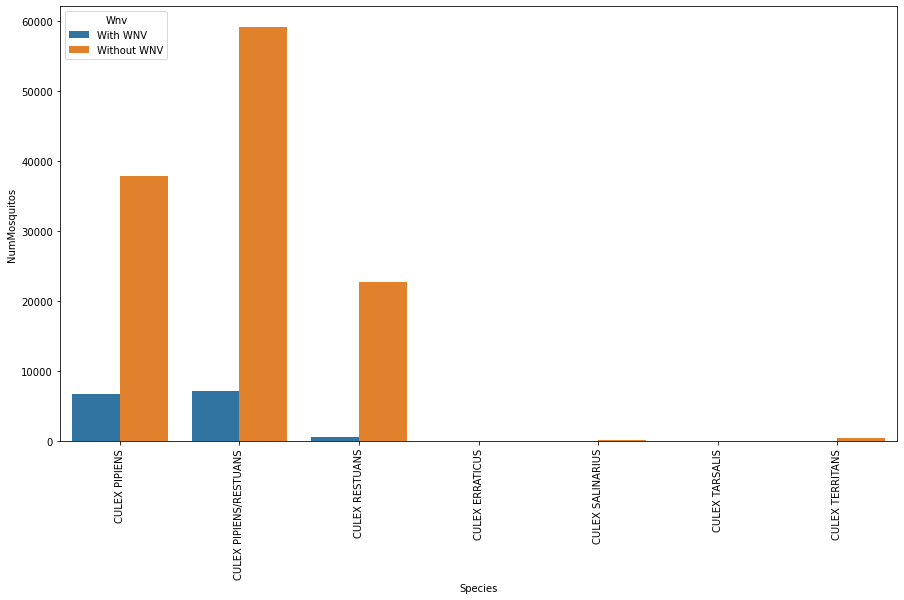

In [90]:
# Mosquito species with/without WNV
plt.figure(figsize =(15,8))
plt.xticks(rotation=90)
sns.barplot(data=df_species, x=df_species.index, y='NumMosquitos', hue='Wnv')

- Main mosquito species carrying WNV are CULEX PIPENS and CULEX RESTUANS
- More than 90% species of mosquito belong to CULEX PIPENS and CULEX RESTUANS

In [91]:
# number of mosquitoes by month
df_train_month_0 = df_train_final_0.resample('M').sum()
df_train_month_1 = df_train_final_1.resample('M').sum()

Text(0.5, 0, 'Time')

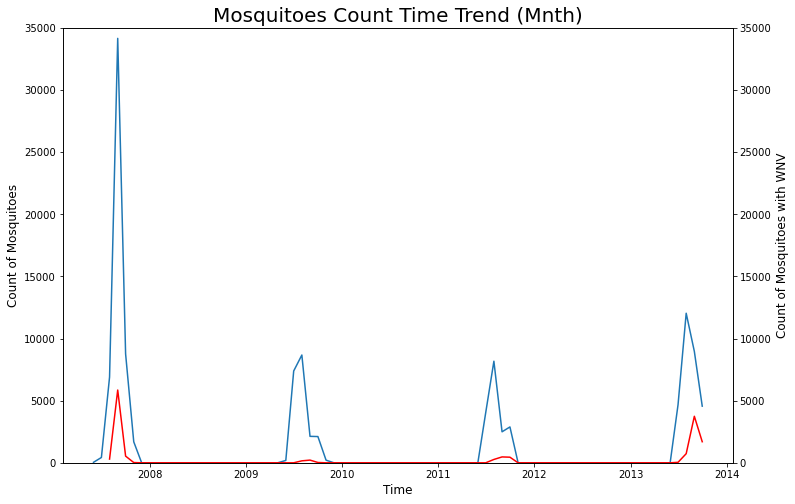

In [92]:
# Number of mosquitoes time trend (month):
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df_train_month_0['NumMosquitos'])
ax2 = ax1.twinx()
ax2.plot(df_train_month_1['NumMosquitos'], color = "red")
ax1.set_ylim([0, 35000])
ax2.set_ylim([0, 35000])
plt.title("Mosquitoes Count Time Trend (Mnth)", fontsize = 20)
ax1.set_ylabel("Count of Mosquitoes", fontsize = 12)
ax2.set_ylabel("Count of Mosquitoes with WNV",fontsize = 12)
ax1.set_xlabel("Time", fontsize = 12)

- By week, sub plot by year data
- compare to the spray data
- include the spray dates by plotting against 1/0

In [93]:
# number of mosquitoes by year
df_train_year_0 = df_train_final_0.resample('Y').sum()
df_train_year_1 = df_train_final_1.resample('Y').sum()

# append both datasets together
df_train_year = df_train_year_0.append(df_train_year_1)
df_train_year

,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station
Date,,,,,,
2007-12-31,149478.204330,-313410.884667,26705,51974,0,5933.0
2008-12-31,0.000000,0.000000,0,0,0,0.0
2009-12-31,93339.780567,-195616.352542,17857,20708,0,3337.0
2010-12-31,0.000000,0.000000,0,0,0,0.0
2011-12-31,83593.351843,-175176.448892,15936,17606,0,2979.0
2012-12-31,0.000000,0.000000,0,0,0,0.0
2013-12-31,90109.627955,-188835.258036,17318,30232,0,3270.0
2007-12-31,9865.560256,-20691.767390,1728,6714,236,394.0
2008-12-31,0.000000,0.000000,0,0,0,0.0


In [94]:
#drop even year columns without data
df_train_year.drop(["2008-12-31","2010-12-31","2012-12-31"], inplace = True)

In [95]:
for i in range(0,len(df_train_year)):
    if df_train_year.iloc[i,4] > 0:
        df_train_year.iloc[i,4] = "Yes"
    else:
        df_train_year.iloc[i,4] = "No"

df_train_year

,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Station
Date,,,,,,
2007-12-31,149478.204330,-313410.884667,26705,51974,No,5933.0
2009-12-31,93339.780567,-195616.352542,17857,20708,No,3337.0
2011-12-31,83593.351843,-175176.448892,15936,17606,No,2979.0
2013-12-31,90109.627955,-188835.258036,17318,30232,No,3270.0
2007-12-31,9865.560256,-20691.767390,1728,6714,Yes,394.0
2009-12-31,795.353659,-1667.515920,151,400,Yes,27.0
2011-12-31,2389.535292,-5005.302861,463,1193,Yes,69.0
2013-12-31,10011.595476,-20971.702964,1994,6212,Yes,324.0


Text(0, 0.5, 'Count')

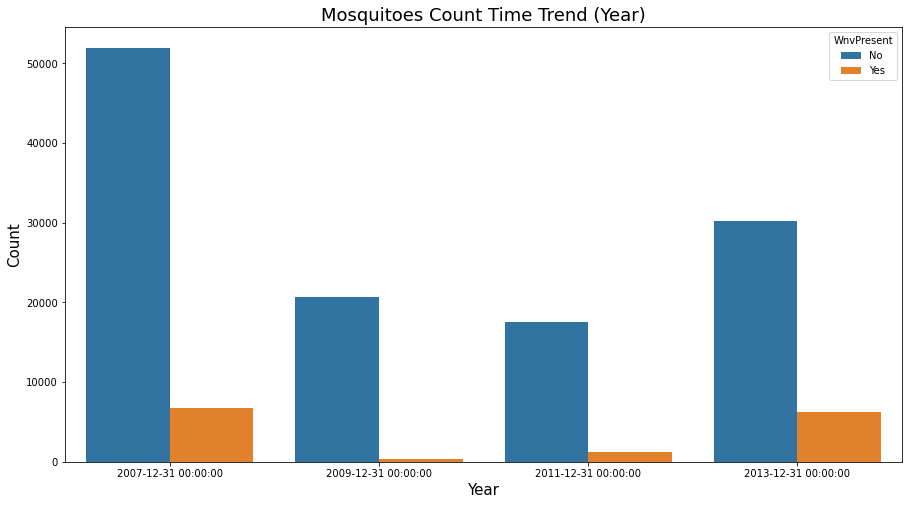

In [96]:
# Number of mosquitoes time trend (year):
plt.figure(figsize =(15,8))
sns.barplot(data=df_train_year, x=df_train_year.index, y='NumMosquitos', hue='WnvPresent')
plt.title("Mosquitoes Count Time Trend (Year)", fontsize = 18)
plt.xlabel("Year",fontsize = 15)
plt.ylabel("Count",fontsize = 15)

- Observe large decrease in mosquito count from 2007 to 2009 even though the spray efforts were from:2011-08-29 to:2013-09-05 
- Spray efforts done in 2011 and 2013, seems rather ineffective

##### Location

In [97]:
# Top 15 locations with most Mosquitoes:
df_train_top = df_train_final.groupby("Trap").NumMosquitos.sum().sort_values(ascending = False).head(15)
df_train_top

Trap
T115    21668
T900    15386
T138     9936
T002     3710
T128     3315
T135     3122
T103     2988
T008     2668
T212     2595
T158     2575
T903     2327
T114     2161
T225     2014
T151     1969
T009     1940
Name: NumMosquitos, dtype: int64

In [98]:
# for mosquitoes without West Nile Virus (Wnv)
df_loc_0 = pd.DataFrame(df_train_final_0.groupby("Trap").NumMosquitos.sum())
df_loc_0["Wnv Present"] = "Yes"
df_loc_0.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv Present
Trap,,
T115,19790,Yes
T900,13326,Yes
T138,9177,Yes
T002,3210,Yes
T128,2833,Yes
T135,2806,Yes
T103,2715,Yes
T212,2500,Yes
T158,2389,Yes


In [99]:
# for mosquitoes with West Nile Virus (Wnv)
df_loc_1 = pd.DataFrame(df_train_final_1.groupby("Trap").NumMosquitos.sum())
df_loc_1["Wnv Present"] = "No"
df_loc_1.sort_values("NumMosquitos",ascending = False)

,NumMosquitos,Wnv Present
Trap,,
T900,2060,No
T115,1878,No
T138,759,No
T002,500,No
T128,482,No
T003,380,No
T008,330,No
T135,316,No
T013,316,No


In [100]:
# append both dataframes
df_loc = df_loc_1.append(df_loc_0)
df_loc

,NumMosquitos,Wnv Present
Trap,,
T002,500,No
T003,380,No
T005,17,No
T006,46,No
T008,330,No
...,...,...
T236,365,Yes
T237,18,Yes
T238,34,Yes


In [101]:
# filter out to top 15 locations with most mosquitoes
df_loc_filter = df_loc.loc[['T115', 'T900', 'T138', 'T002', 'T128', 'T135', 'T103', 'T008', 'T212',
       'T158', 'T903', 'T114', 'T225', 'T151', 'T009'],:]

<AxesSubplot:xlabel='Trap', ylabel='NumMosquitos'>

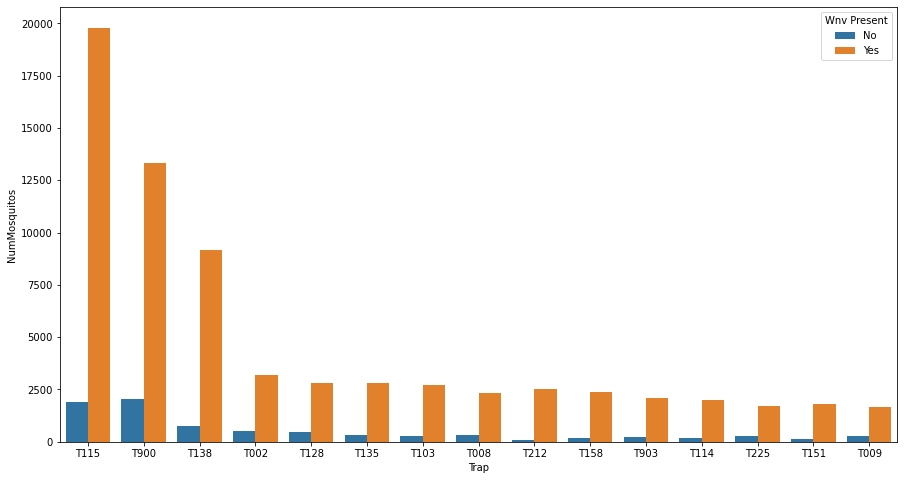

In [102]:
# Mosquito counts with/without WNV for locations in top 15 
plt.figure(figsize =(15,8))
sns.barplot(data=df_loc_filter, x=df_loc_filter.index, y='NumMosquitos', hue='Wnv Present')

Top 5 locations with most overall mosquitoes over the years include 
- T115 (1200 S DOTY AVE, Chicago, IL) 
- T900 (1000 W OHARE AIRPORT, Chicago, IL)
- T138 (1000 S STONY ISLAND AVE, Chicago, IL)
- T002 (4100 N OAK PARK AVE, Chicago, IL)
- T128 (2400 E 105TH ST, Chicago, IL)

Yanda - find location on map

##### Location by year

In [103]:
# group data by year and trap
df_train_grp = df_train_final.groupby([df_train_final.index.year,"Trap"]).agg(
    NumMosquitos = ("NumMosquitos", "sum"),
    WnvPresent = ("WnvPresent","mean"))

# group data by year
df_train_grp_year = df_train_final.groupby([df_train_final.index.year]).agg(
    NumMosquitos = ("NumMosquitos", "sum"),
    WnvPresent = ("WnvPresent","mean"))

display(df_train_grp)
display(df_train_grp_year)

NumMosquitos  WnvPresent
Date Trap                          
2007 T001            25    0.000000
     T002           740    0.163265
     T003           214    0.133333
     T004            59    0.000000
     T005            50    0.142857
...                 ...         ...
2013 T233           665    0.205882
     T235           395    0.225806
     T236           358    0.037037
     T900          5689    0.193277
     T903           194    0.000000

[343 rows x 2 columns]

,NumMosquitos,WnvPresent
Date,,
2007,58688,0.061926
2009,21108,0.008448
2011,18799,0.027751
2013,36444,0.099916


In [104]:
# reset index
df_train_grp = df_train_grp.reset_index()

In [105]:
df_train_plot = df_train_grp[(df_train_grp["Trap"] == 'T115') | (df_train_grp["Trap"] == 'T900') | (df_train_grp["Trap"] == 'T138') | (df_train_grp["Trap"] == 'T002') | (df_train_grp["Trap"] == 'T128')]

In [106]:
df_train_plot

,Date,Trap,NumMosquitos,WnvPresent
1,2007,T002,740,0.163265
80,2007,T115,19134,0.088235
81,2007,T128,2532,0.132353
84,2007,T138,9321,0.068966
116,2009,T002,818,0.021739
157,2009,T115,529,0.000000
158,2009,T128,72,0.000000
160,2009,T138,94,0.000000
187,2009,T900,5488,0.007326
189,2011,T002,360,0.033333


<AxesSubplot:xlabel='Date', ylabel='NumMosquitos'>

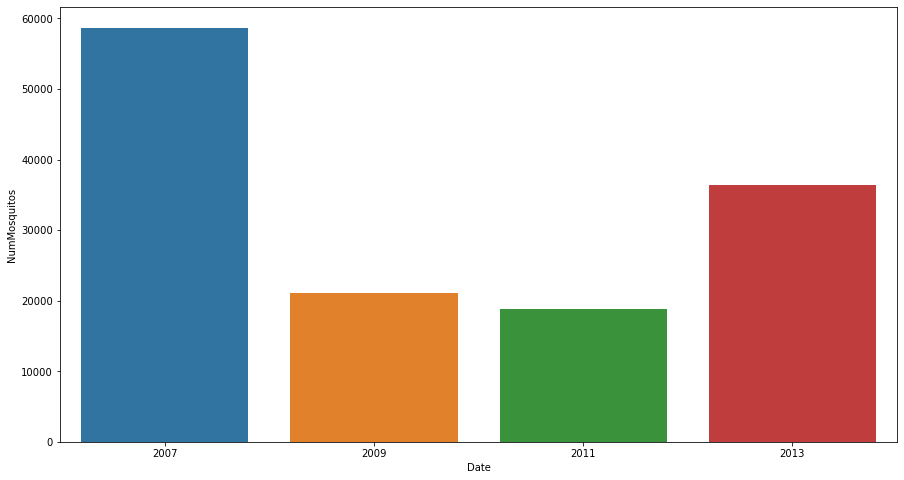

In [107]:
plt.figure(figsize =(15,8))
sns.barplot(data = df_train_grp_year, x = df_train_grp_year.index, y='NumMosquitos')

- Observe that the spray efforts in 2011 and 2013 did not have a significant impact in reducing the mosquito counts for year 2011 to 2013. An increase in mosquitoes were observed, from 20,000 to ~40,000

<AxesSubplot:xlabel='Date', ylabel='NumMosquitos'>

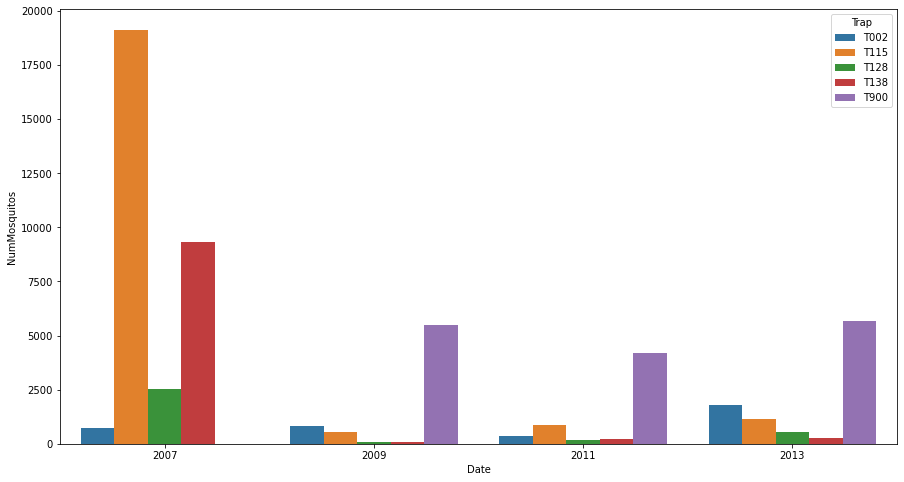

In [108]:
plt.figure(figsize =(15,8))
sns.barplot(data=df_train_plot, x="Date", y='NumMosquitos', hue='Trap')

- Observe that the spray efforts in 2011 and 2013 did not have a significant impact in reducing the mosquito counts for T900 trap, which had a relatively similar mosquito count of ~4000 to ~6000 from 2009 to 2013.
- Observe large decrease in mosquito count from 2007 to 2009 even though the spray efforts were in 2011 and 2013.

### Spray dataset

In [109]:
df_spray.head()

,Date,Time,Latitude,Longitude
datetime,,,,
2011-08-29 18:56:58,2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29 18:57:08,2011-08-29,6:57:08 PM,42.391348,-88.089163
2011-08-29 18:57:18,2011-08-29,6:57:18 PM,42.391022,-88.089157
2011-08-29 18:57:28,2011-08-29,6:57:28 PM,42.390637,-88.089158
2011-08-29 18:57:38,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [110]:
# hist
df_spray_day = df_spray.resample("D").count()
df_spray_day

,Date,Time,Latitude,Longitude
datetime,,,,
2011-08-29,95,95,95,95
2011-08-30,0,0,0,0
2011-08-31,0,0,0,0
2011-09-01,0,0,0,0
2011-09-02,0,0,0,0
...,...,...,...,...
2013-09-01,0,0,0,0
2013-09-02,0,0,0,0
2013-09-03,0,0,0,0


In [111]:
df_spray_month = df_spray_day.resample("M").count()
df_spray_month

,Date,Time,Latitude,Longitude
datetime,,,,
2011-08-31,3,3,3,3
2011-09-30,30,30,30,30
2011-10-31,31,31,31,31
2011-11-30,30,30,30,30
2011-12-31,31,31,31,31
2012-01-31,31,31,31,31
2012-02-29,29,29,29,29
2012-03-31,31,31,31,31
2012-04-30,30,30,30,30


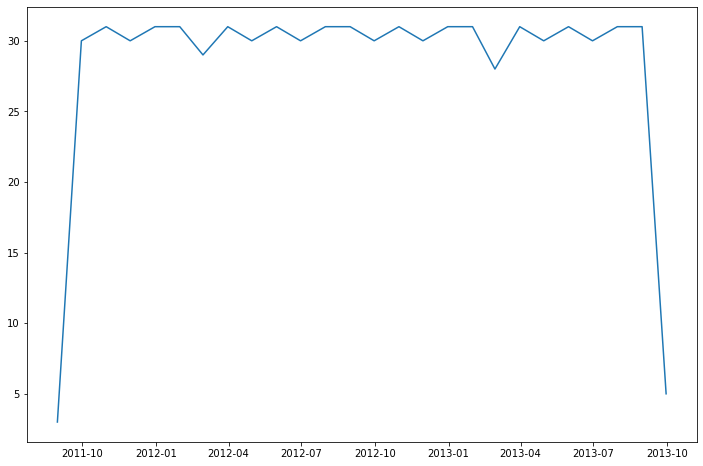

In [112]:
plt.figure(figsize=(12,8))
plt.plot(df_spray_month["Date"])

### Weather dataset

#### Temperature delta between stations

In [113]:
# converting Date in train dataset to python readable date-time format
df_weather_1['Date'] = pd.to_datetime(df_weather_1['Date'])
df_weather_2['Date'] = pd.to_datetime(df_weather_2['Date'])

In [114]:
# cal delta between Temperature readings for station 1 and station 2
df_weather_1["Tmax_delta"] = df_weather_1["Tmax"]-df_weather_2["Tmax"]
df_weather_1["Tmin_delta"] = df_weather_1["Tmin"]-df_weather_2["Tmin"]
df_weather_1["Tavg_delta"] = df_weather_1["Tavg"]-df_weather_2["Tavg"]

In [115]:
# Set date as index
df_weather_1.set_index('Date', inplace=True)

Text(0.5, 0, 'Time')

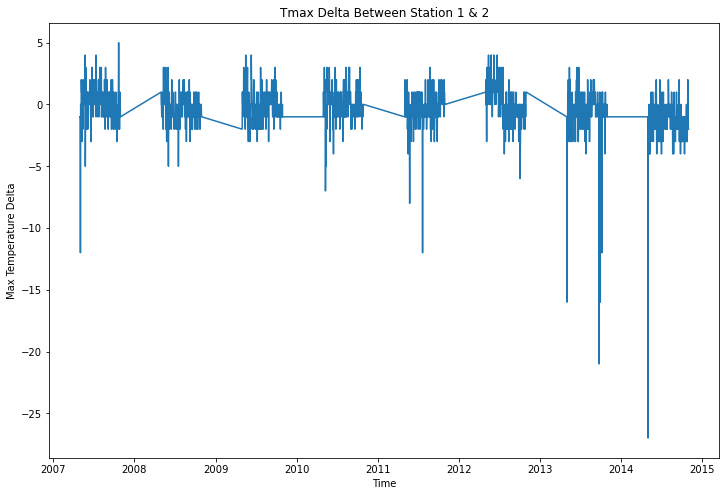

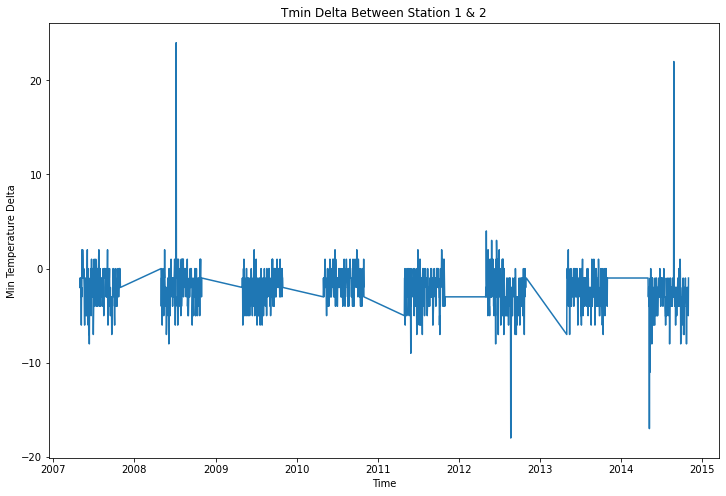

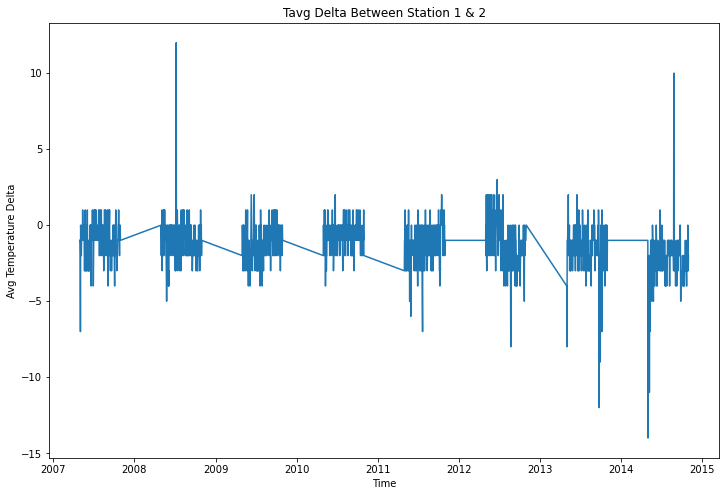

In [116]:
plt.figure(figsize=(12,8))
plt.plot(df_weather_1["Tmax_delta"])
plt.title("Tmax Delta Between Station 1 & 2")
plt.ylabel("Max Temperature Delta")
plt.xlabel("Time")

plt.figure(figsize=(12,8))
plt.plot(df_weather_1["Tmin_delta"])
plt.title("Tmin Delta Between Station 1 & 2")
plt.ylabel("Min Temperature Delta")
plt.xlabel("Time")

plt.figure(figsize=(12,8))
plt.plot(df_weather_1["Tavg_delta"])
plt.title("Tavg Delta Between Station 1 & 2")
plt.ylabel("Avg Temperature Delta")
plt.xlabel("Time")

- delta average temperature (Fahrenheit) is in the range of 5 to 10 (absolute value). delta of 10 degF = ~5.5 degC delta.
- formula: Δ°C x 9/5= Δ°F

##### Time Trend

In [117]:
# Time period available
for i in range(2007,2014,2):
    print(f'{i} min : {df_merged[df_merged["Date"].dt.year == i]["Date"].min()}'
         f'{i} max : {df_merged[df_merged["Date"].dt.year == i]["Date"].max()}')

2007 min : 2007-05-29 00:00:002007 max : 2007-10-09 00:00:00
2009 min : 2009-05-28 00:00:002009 max : 2009-10-01 00:00:00
2011 min : 2011-06-10 00:00:002011 max : 2011-09-30 00:00:00
2013 min : 2013-06-07 00:00:002013 max : 2013-09-26 00:00:00


In [118]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10506 entries, 0 to 10505
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Date               10506 non-null  datetime64[ns] 
 1   Species            10506 non-null  object         
 2   Trap               10506 non-null  object         
 3   Latitude           10506 non-null  float64        
 4   Longitude          10506 non-null  float64        
 5   AddressAccuracy    10506 non-null  int64          
 6   NumMosquitos       10506 non-null  int64          
 7   WnvPresent         10506 non-null  int64          
 8   Station            10506 non-null  float64        
 9   Tmax               10506 non-null  int64          
 10  Tmin               10506 non-null  int64          
 11  Tavg               10506 non-null  float64        
 12  Depart             10506 non-null  float64        
 13  DewPoint           10506 non-null  int64      

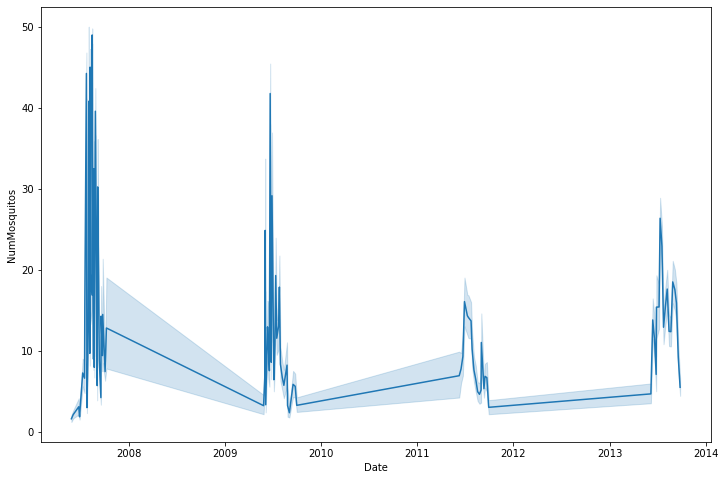

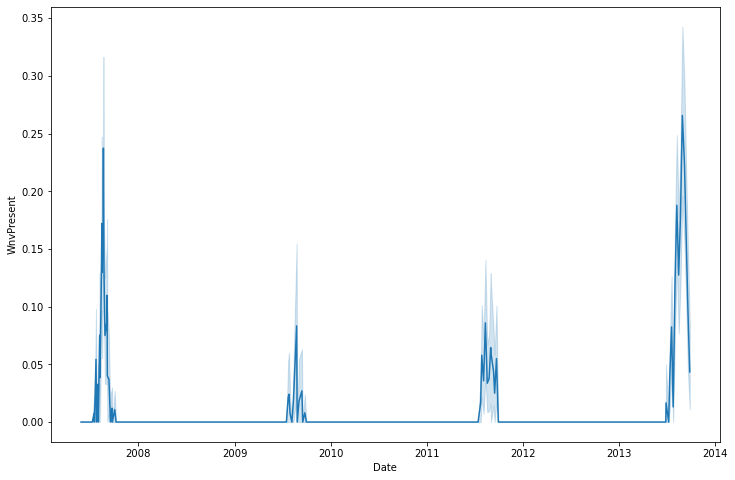

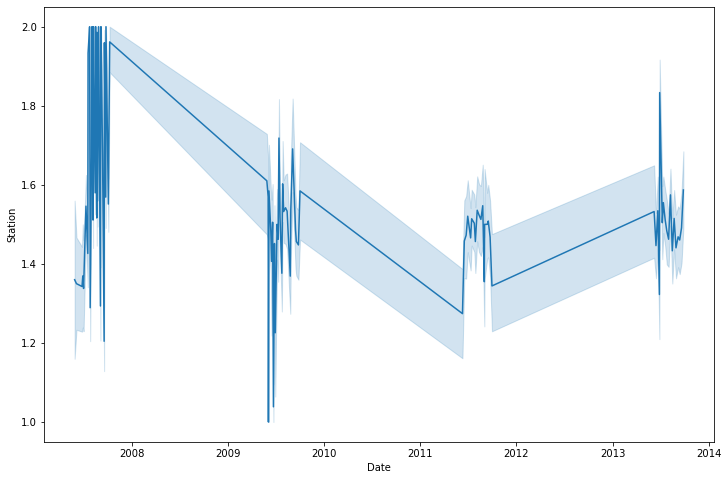

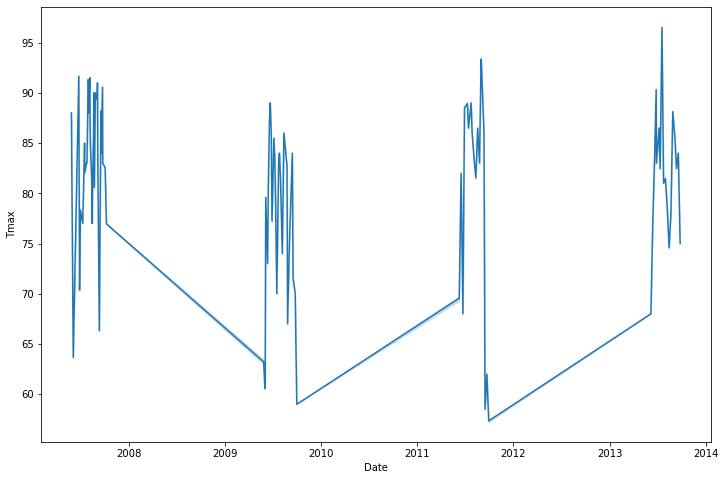

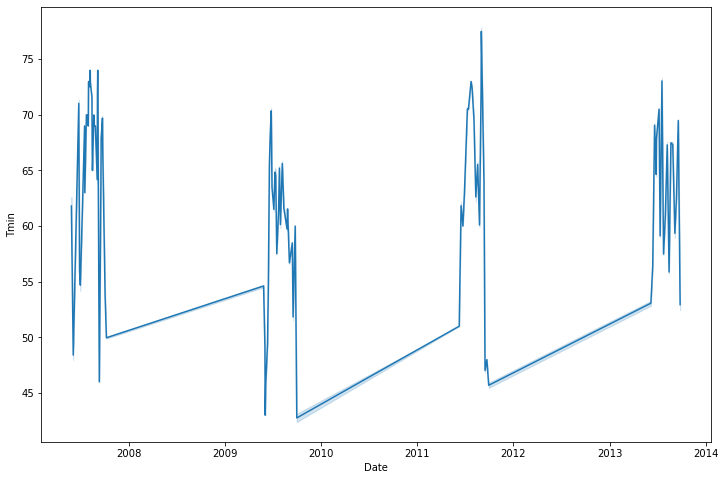

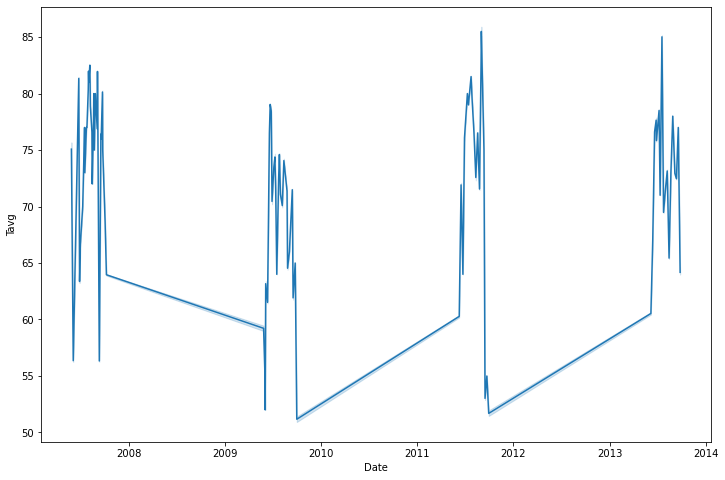

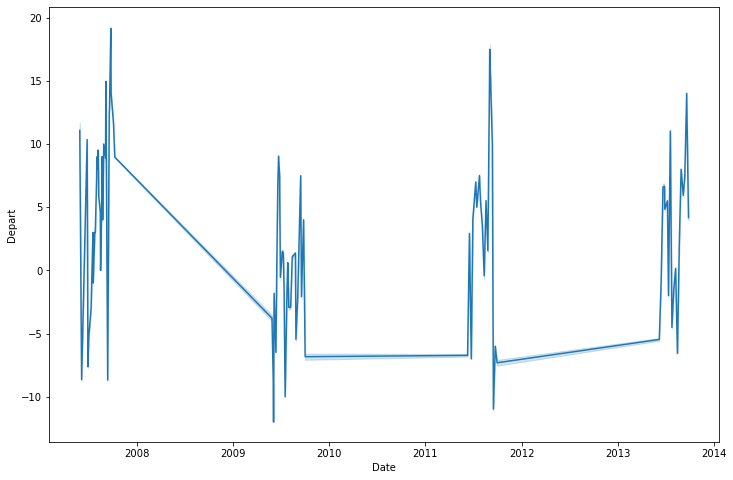

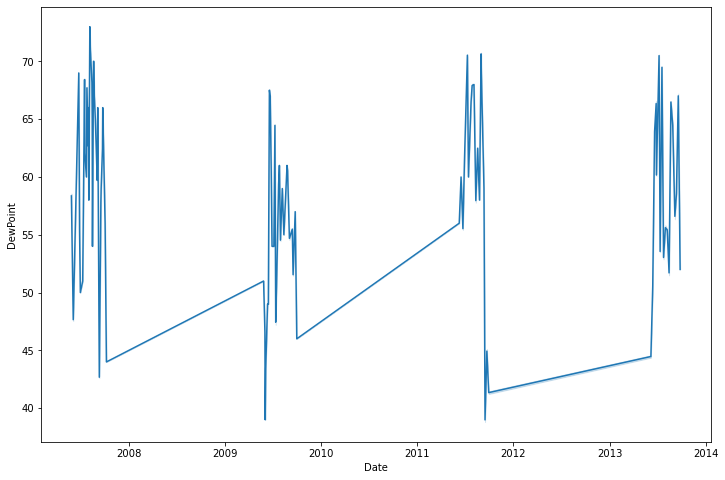

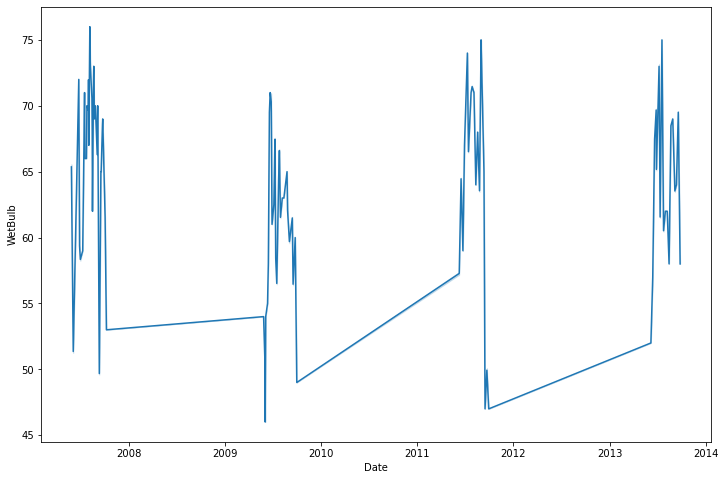

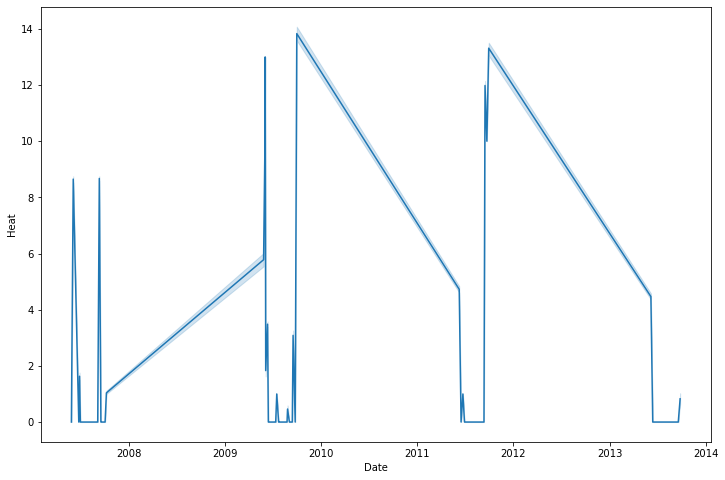

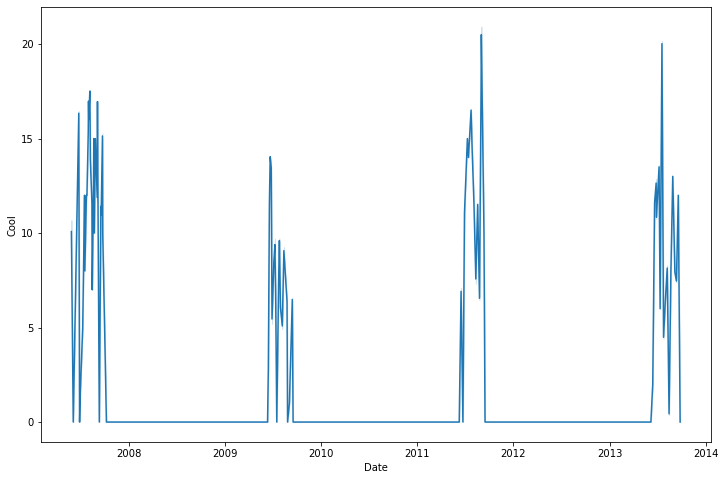

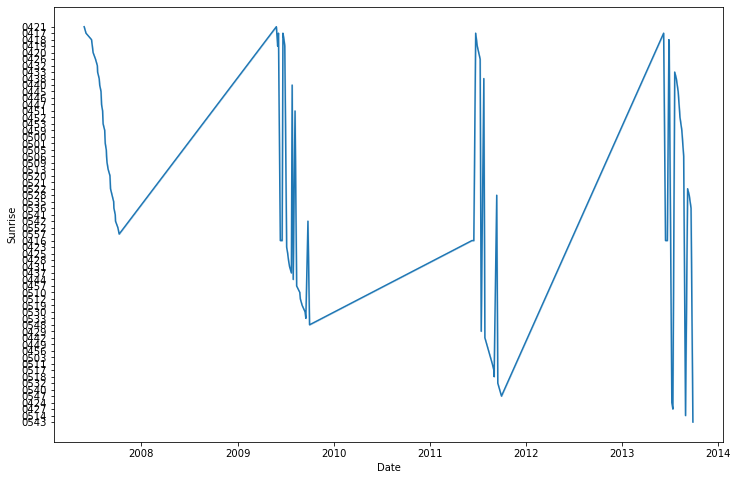

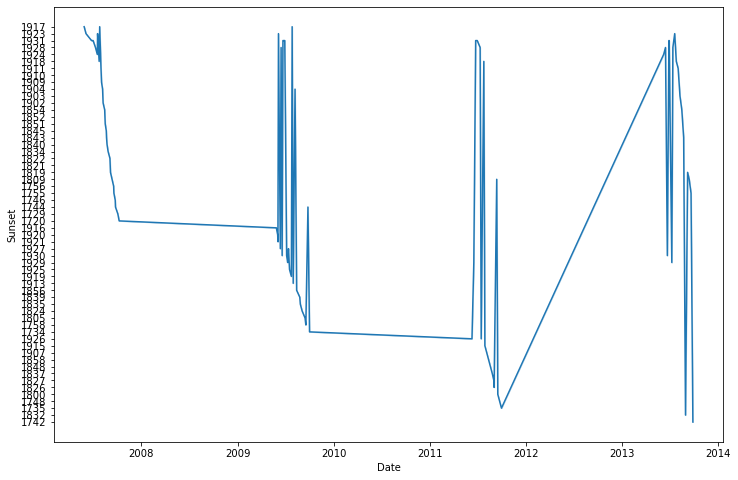

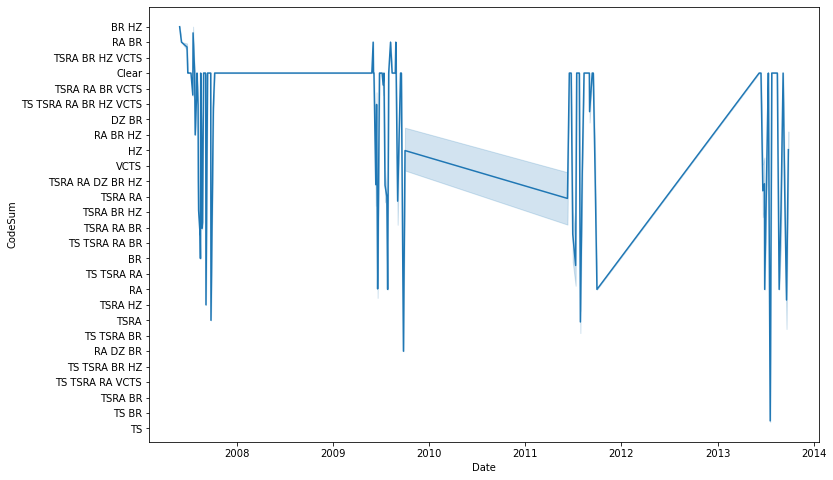

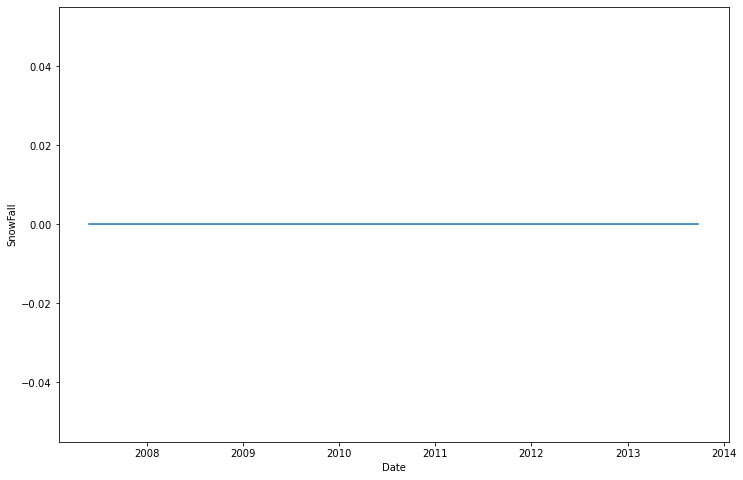

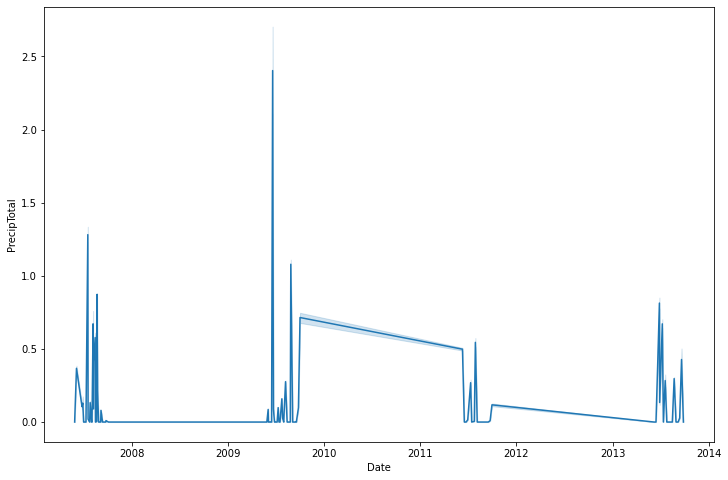

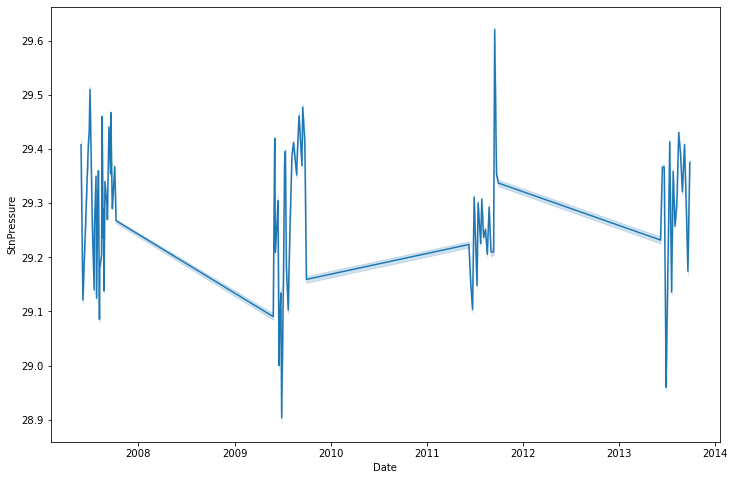

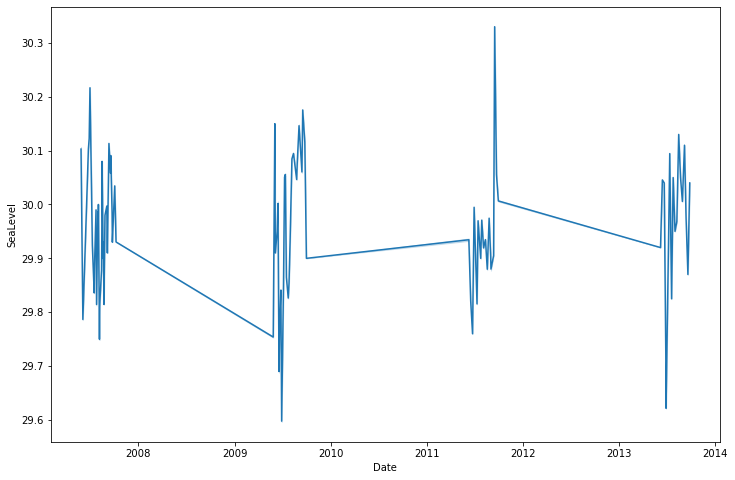

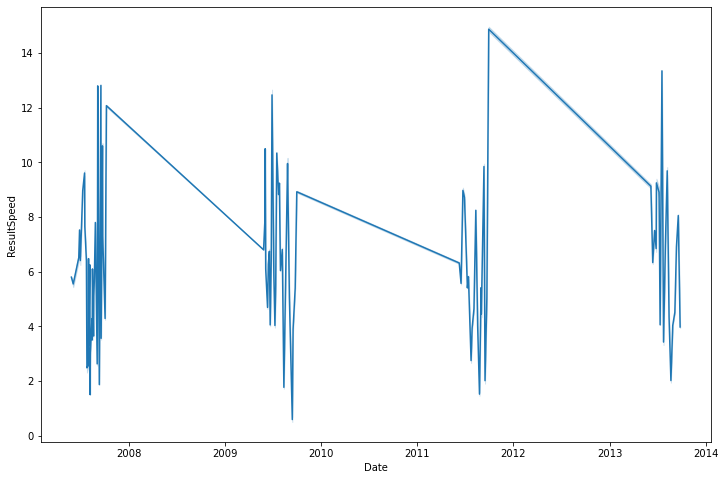

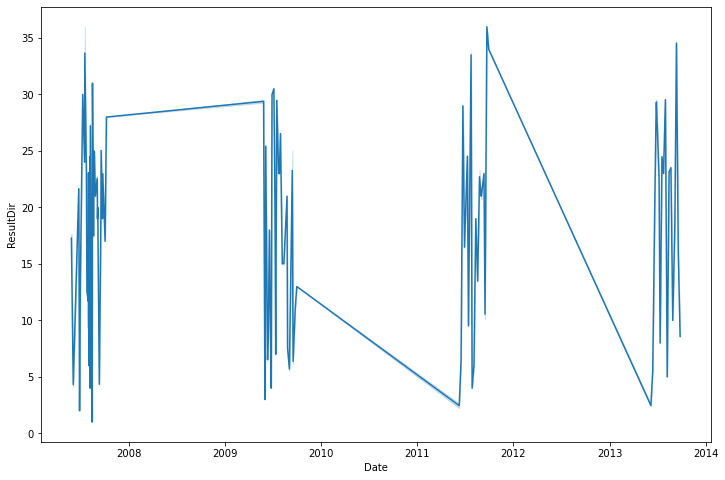

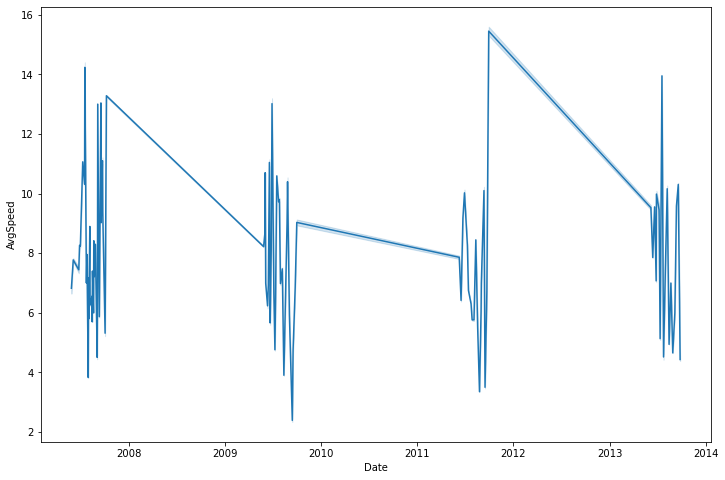

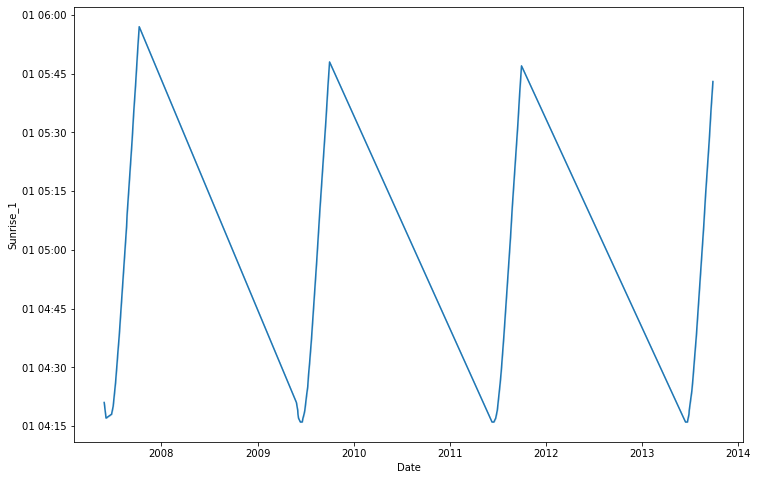

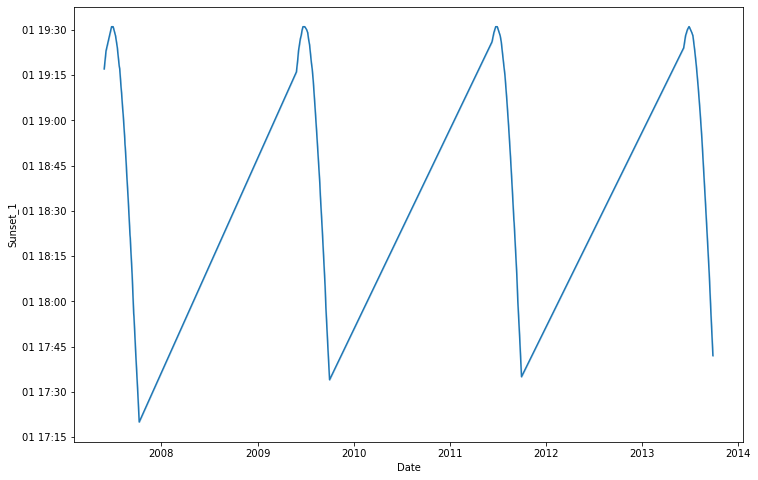

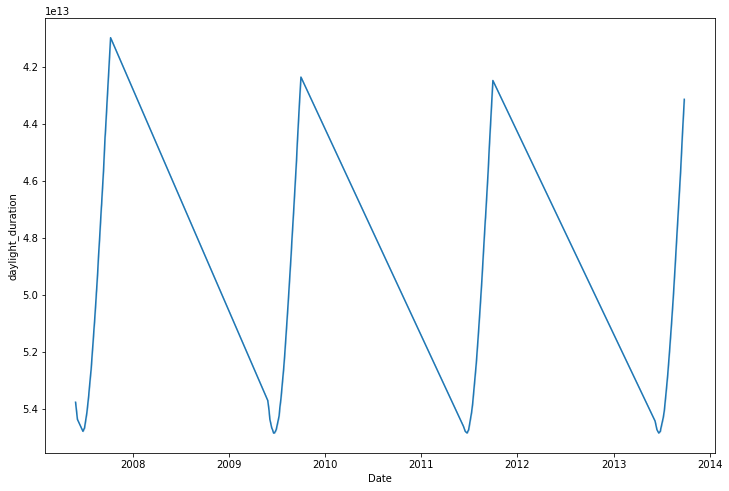

In [119]:
for i in df_merged.iloc[:,range(6,30)].columns:
    plt.figure(figsize=(12,8))
    sns.lineplot(data=df_merged, x=df_merged["Date"], y=df_merged[i], palette="rainbow")

In [120]:
# drop snowfall since the period has no snow
df_merged.drop("SnowFall",axis = 1, inplace = True)

In [121]:
df_merged = df_merged.reset_index()

#### Heatplot Map

In [122]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   index              10506 non-null  int64          
 1   Date               10506 non-null  datetime64[ns] 
 2   Species            10506 non-null  object         
 3   Trap               10506 non-null  object         
 4   Latitude           10506 non-null  float64        
 5   Longitude          10506 non-null  float64        
 6   AddressAccuracy    10506 non-null  int64          
 7   NumMosquitos       10506 non-null  int64          
 8   WnvPresent         10506 non-null  int64          
 9   Station            10506 non-null  float64        
 10  Tmax               10506 non-null  int64          
 11  Tmin               10506 non-null  int64          
 12  Tavg               10506 non-null  float64        
 13  Depart             10506 non-null  float64    

<AxesSubplot:>

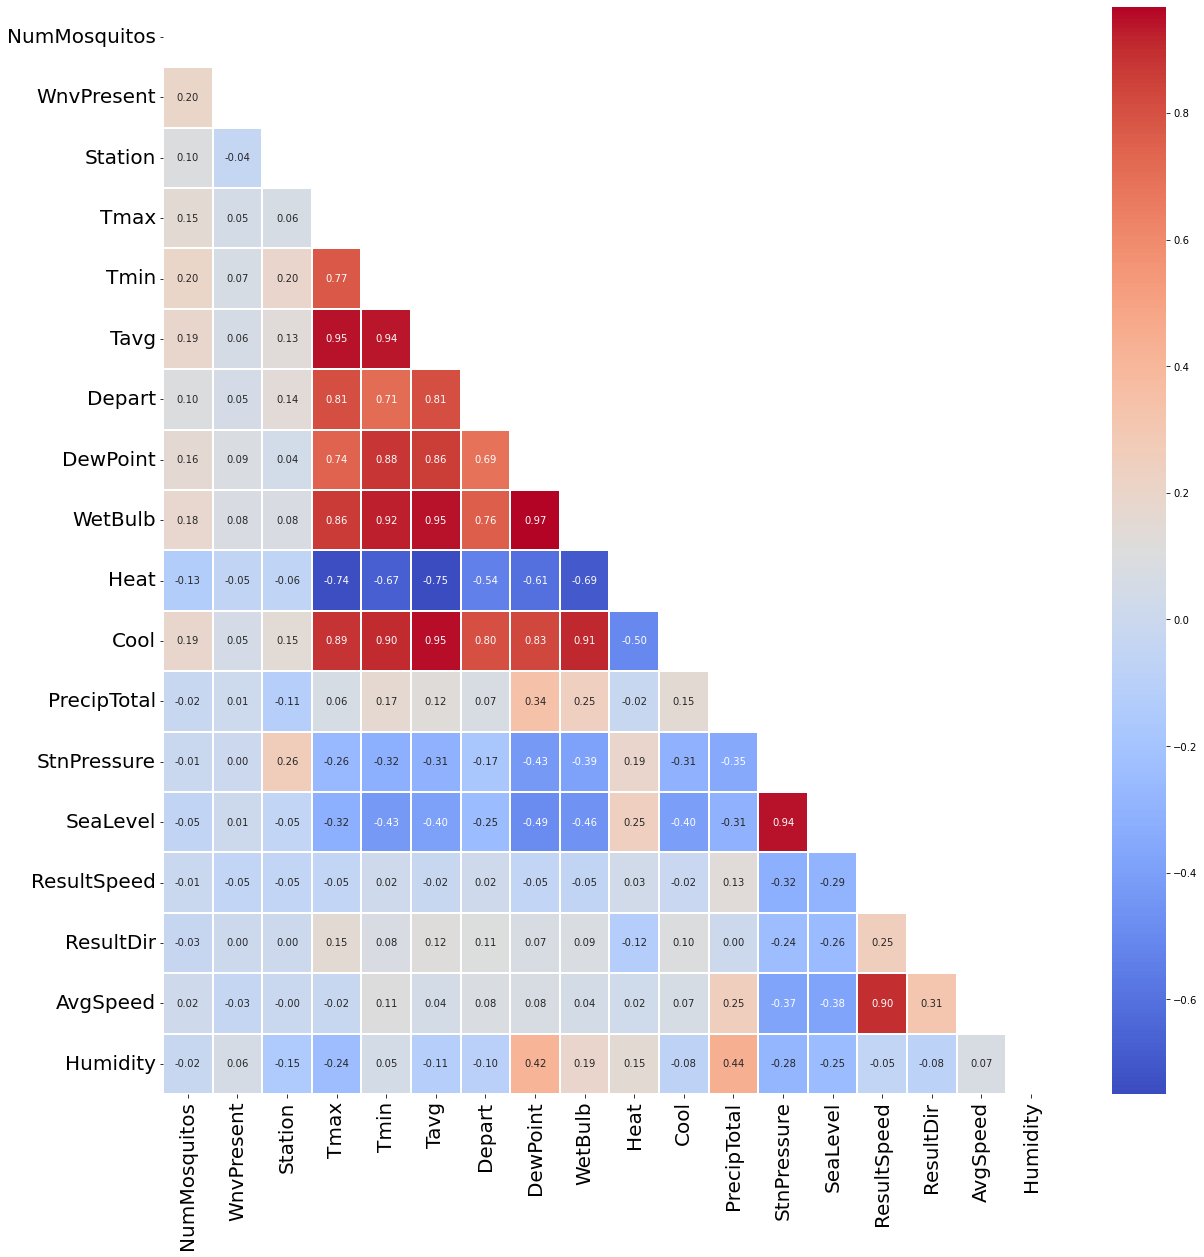

In [123]:
#heatmap for non-object features
mask = np.zeros_like(df_merged.iloc[:,range(7,31)].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(20,20))
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
sns.heatmap(
    df_merged.iloc[:,range(7,31)].corr(),
    cmap='coolwarm',
    annot=True,
    fmt = ".2f",
    mask = mask,
    linewidth = 0.3)

Drop features with high colinearity >0.85
- ResultSpeed (AvgSpeed)
- StnPressure (SeaLevel)
- Tmin, Tmax, DewPoint, WetBulb, Cool, (Tavg)

In [124]:
# drop features with high colinearity, and drop sunrise, sunset.
df_merged_final = df_merged.drop(["index","ResultSpeed","StnPressure","Tmin", "Tmax", "DewPoint", "WetBulb", "Cool", "Sunrise", "Sunset"],axis = 1)

In [125]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Date               10506 non-null  datetime64[ns] 
 1   Species            10506 non-null  object         
 2   Trap               10506 non-null  object         
 3   Latitude           10506 non-null  float64        
 4   Longitude          10506 non-null  float64        
 5   AddressAccuracy    10506 non-null  int64          
 6   NumMosquitos       10506 non-null  int64          
 7   WnvPresent         10506 non-null  int64          
 8   Station            10506 non-null  float64        
 9   Tavg               10506 non-null  float64        
 10  Depart             10506 non-null  float64        
 11  Heat               10506 non-null  float64        
 12  CodeSum            10506 non-null  object         
 13  PrecipTotal        10506 non-null  float64    

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U2'), dtype('float64')) -> None

<Figure size 864x576 with 0 Axes>

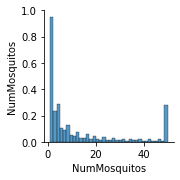

<Figure size 864x576 with 0 Axes>

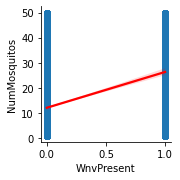

<Figure size 864x576 with 0 Axes>

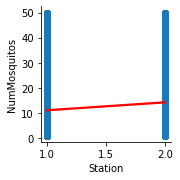

<Figure size 864x576 with 0 Axes>

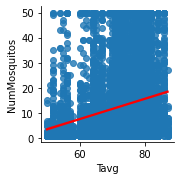

<Figure size 864x576 with 0 Axes>

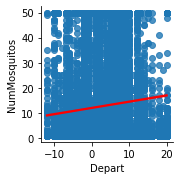

<Figure size 864x576 with 0 Axes>

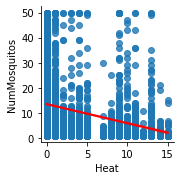

<Figure size 864x576 with 0 Axes>

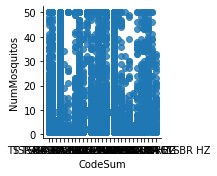

In [132]:
for i in df_merged_final.iloc[:,range(6,20)].columns:
    plt.figure(figsize=(12,8))
    sns.pairplot(data = df_merged, y_vars=['NumMosquitos'], x_vars=i, kind='reg', plot_kws={'line_kws':{'color':'red'}})

In [128]:
# Export dataset
df_merged_final.to_csv('../assets/df_merge_final.csv', index=False)